<a href="https://colab.research.google.com/github/lzumta/Reinforcement-Learning-Assignment/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment

In [150]:
# Import 

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
import time

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [151]:
## INITIALISE THE ENVIRONMENT
size_board = 4
env=Chess_Env(size_board)

In [152]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)
print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    #np.random.seed(42)
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('-----------------')
    print(X)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 0 3]
 [0 2 0 0]
 [0 0 1 0]
 [0 0 0 0]]
check?  0
dofk2  0

[[0 0 3 0]
 [0 0 0 0]
 [0 2 1 0]
 [0 0 0 0]]
0  0
-----------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
check?  0
dofk2  0

[[0 0 0 3]
 [2 0 0 0]
 [0 0 1 0]
 [0 0 0 0]]
0  0
-----------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
check?  0
dofk2  1

[[0 0 0 3]
 [0 0 0 0]
 [2 0 1 0]
 [0 0 0 0]]
0  1
-----------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
check?  0
dofk2  0


In [153]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 
np.random.seed(42)
S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):

    if n % 500 == 0 and n != 0:
      print('Average reward:',np.mean(R_save_random[n-500:n]),'Number of steps: ',np.mean(N_moves_save_random[n-500:n]))
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE

    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)
            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))


Average reward: 0.206 Number of steps:  7.29
Random_Agent, Average reward: 0.186 Number of steps:  7.151


In [154]:
# moving average
def moving_average(a, n):
    """ A function to compute moving averages"""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
#print(moving_average(R_save, n=500))

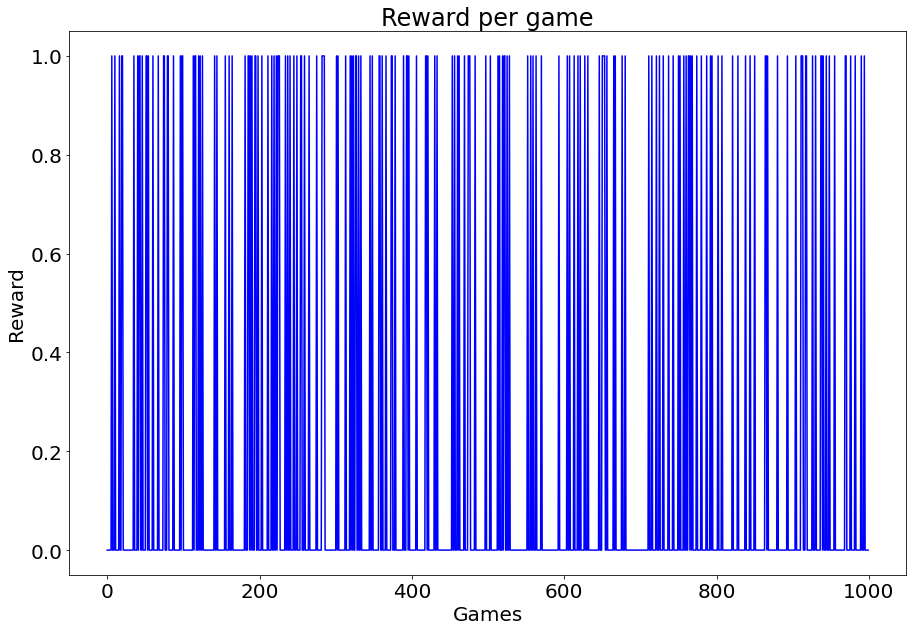

In [188]:
plt.rcParams.update({'font.size': 20})

plt.plot(figsize=(15,10))

plt.plot(np.arange(0,1000), R_save_random, 'b')
plt.title("Reward per game")
plt.xlabel("Games")
plt.ylabel("Reward")
plt.show()

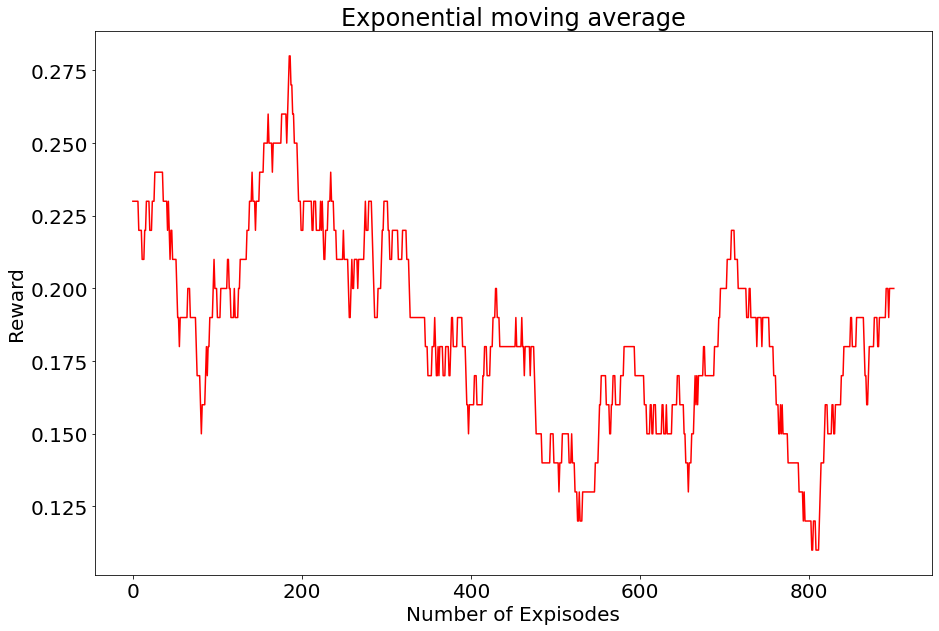

In [189]:
plt.rcParams.update({'font.size': 20})

plt.plot(figsize=(15,10))
plt.plot(np.arange(0,1000-99), moving_average(R_save_random, n=100), 'r')
plt.title("Exponential moving average")
plt.xlabel("Number of Expisodes")
plt.ylabel("Reward")
plt.show()

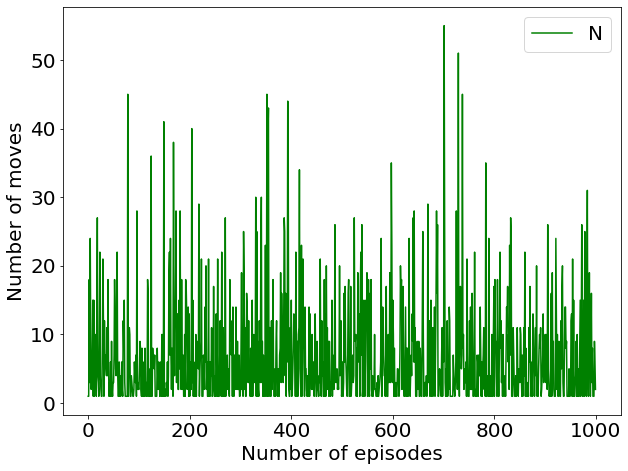

In [202]:
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (10,7.5)

plt.plot(np.arange(0,1000),N_moves_save_random,'g')
plt.legend('Number of moves')
plt.xlabel('Number of episodes')
plt.ylabel('Number of moves')
plt.show()

In [157]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES



## INITALISE THE NEURAL NETWORK...
class Neural_Netork(nn.Module):
    def __init__(self):
        super(Neural_Netork, self).__init__()
        self.fc1 = nn.Linear(N_in, N_h)
        self.out = nn.Linear(N_h, N_a)

    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        action = self.out(x)
        return action


In [158]:
class ChessAgent():
    def __init__(self):
        super(ChessAgent, self).__init__()
        self.policy_net = Neural_Netork()
        self.target_net = Neural_Netork()

        self.learn_step_counter = 0
        self.memory_counter = 0
        self.memory_q = np.zeros((memory_size, N_in * 2 + 2))
        self.memory_sarsa = np.zeros((memory_size, N_in * 2 + 4))
        
        self.optimizer = torch.optim.SGD(self.policy_net.parameters(), lr=eta)
        self.loss_function = nn.MSELoss()

    def choose_action(self, state, allowed_a, epsilon_f):
        state = torch.unsqueeze(torch.FloatTensor(state), 0) # get a 1D array
        a,_=np.where(allowed_a==1) # get indexes of allowed actions
        if np.random.random() > epsilon_f: # greedy policy
            # Exploitation
            action_value = self.policy_net.forward(state)
            actions = torch.detach(action_value).numpy()
            actions = [actions[0][i] for i in a]
            action = np.argmax(actions)
            action = a[action]
        else: # random policy
            # Exploration
            action = np.random.permutation(a)[0]
        return action


    def store_transition_q(self, state, action, reward, next_state):
        transition = np.hstack((state, [action, reward], next_state))
        index = self.memory_counter % memory_size
        self.memory_q[index, :] = transition
        self.memory_counter += 1

    def store_transition_sarsa(self, state, action1, action2, reward, next_state, done):
        transition = np.hstack((state, [action1, action2, reward, done], next_state))
        index = self.memory_counter % memory_size
        self.memory_sarsa[index, :] = transition
        self.memory_counter += 1

    def train_q(self):

        #update the parameters
        if self.learn_step_counter % 100 ==0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        self.learn_step_counter+=1

        #sample batch from memory
        sample_index = np.random.choice(memory_size, 32)
        batch_memory = self.memory_q[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :N_in])
        batch_action = torch.LongTensor(batch_memory[:, N_in:N_in+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, N_in+1:N_in+2])
        batch_next_state = torch.FloatTensor(batch_memory[:,-N_in:])

        #q_eval
        q_eval = self.policy_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + gamma * q_next.max(1)[0].view(32, 1)
        loss = self.loss_function(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def train_sarsa(self):
        #update the parameters
        if self.learn_step_counter % 100 ==0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        self.learn_step_counter+=1

        #sample batch from memory
        sample_index = np.random.choice(memory_size, 32)
        batch_memory = self.memory_sarsa[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :N_in])
        batch_action1 = torch.LongTensor(batch_memory[:, N_in:N_in+1].astype(int))
        batch_action2 = torch.LongTensor(batch_memory[:, N_in+1:N_in+2].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, N_in+2:N_in+3])
       # batch_done = torch.FloatTensor(batch_memory[:, N_in+3:N_in+4])
        batch_next_state = torch.FloatTensor(batch_memory[:,-N_in:])

        #q_eval
        q_eval = self.policy_net(batch_state).gather(1, batch_action1)          
        q_next = self.target_net(batch_next_state).gather(1, batch_action2)
        q_target = batch_reward + gamma * q_next
        loss = self.loss_function(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Deep Q_Learning Implementation

In [159]:
# HYPERPARAMETERS USED FOR Q_LEARNING (FOR A GRID SIZE OF 4)

epsilon_0 = 0.6    # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.01        # THE LEARNING RATE
N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 
memory_size = 2000 # THE SIZE OF THE MEMORY
reward_draw = 0  # THE REWARD FOR A DRAW, YOU CAN CHANGE THIS TO REPRODUCE OUR RESULTS TO -1
reward_check = 1 # THE REWARD FOR A CHECK

# SAVING VARIABLES
R_save_q = np.zeros([N_episodes, 1])
N_moves_save_q = np.zeros([N_episodes, 1])
Training_time_per_episode_q = np.zeros([N_episodes, 1])

# PRINT AVERAGE REWARD EVERY NUMBER OF EPISODES
print_every = 500

In [160]:
agent = ChessAgent()

print(f"Average rewards for every {print_every} episodes:")
print('---------------------------------------')
for n in range(N_episodes):

    if n % print_every == 0 and n != 0:
      print('Average reward:',np.mean(R_save_q[n-print_every:n]),'Number of steps: ',np.mean(N_moves_save_q[n-print_every:n]), 'Training time: ',np.mean(Training_time_per_episode_q[n-500:n]))

    start = time.time()
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game(reward_draw=reward_draw, reward_check=reward_check)      ## INITIALISE GAME

    ep_reward = 0
    
    while Done==0:                           ## START THE EPISODE
        
    
        action = agent.choose_action(X, allowed_a, epsilon_f)

        S_next,X_next,allowed_a_next,R,Done=env.OneStep(action)
        agent.store_transition_q(X, action, R, X_next)

        if agent.memory_counter >= memory_size:
                agent.train_q()      

        ## THE EPISODE HAS ENDED, UPDATE   
        if Done==1:
          R_save_q[n]=np.copy(R)
          N_moves_save_q[n]=np.copy(i)
          end = time.time()
          Training_time_per_episode_q[n] = abs(start-end)/1000
          break

        # IF THE EPISODE IS NOT OVER, ADD REWARD
        else:
          ep_reward += R
            
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
    
           

Average rewards for every 500 episodes:
---------------------------------------
Average reward: 0.216 Number of steps:  6.654 Training time:  5.1857036113739015e-05
Average reward: 0.276 Number of steps:  5.646 Training time:  7.087810897827148e-05
Average reward: 0.336 Number of steps:  4.928 Training time:  4.690792226791382e-05
Average reward: 0.376 Number of steps:  3.93 Training time:  3.9716528415679936e-05
Average reward: 0.402 Number of steps:  4.028 Training time:  4.1486160278320315e-05
Average reward: 0.42 Number of steps:  3.31 Training time:  3.463313293457031e-05
Average reward: 0.42 Number of steps:  3.206 Training time:  2.9624623298645017e-05
Average reward: 0.446 Number of steps:  3.288 Training time:  3.569663143157958e-05
Average reward: 0.484 Number of steps:  2.722 Training time:  2.8774205207824714e-05
Average reward: 0.45 Number of steps:  2.912 Training time:  2.7012248992919922e-05
Average reward: 0.468 Number of steps:  2.812 Training time:  2.778719139099121

In [191]:
# Print average reward and average number of steps overall
print(f'Results over the whole Q_learning training with {N_episodes} episodes:')
print('Trained_Agent, Average reward:',np.mean(R_save_q),'Number of steps: ',np.mean(N_moves_save_q), 'Average training time: ', np.mean(Training_time_per_episode_q))


Results over the whole Q_learning training with 100000 episodes:
Trained_Agent, Average reward: 0.65191 Number of steps:  2.05328 Average training time:  1.9303096206188203e-05


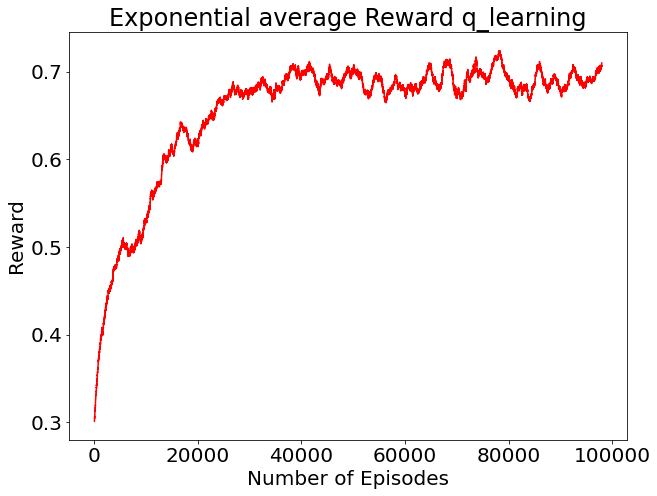

In [203]:
# Plot: Average reward exp
plt.rcParams.update({'font.size': 20})

plt.plot(figsize=(15,10))
plt.plot(np.arange(0,N_episodes-1999), moving_average(R_save_q, n=2000), 'r')
plt.title("Exponential average Reward q_learning")
plt.xlabel("Number of Episodes")
plt.ylabel("Reward")
plt.show()

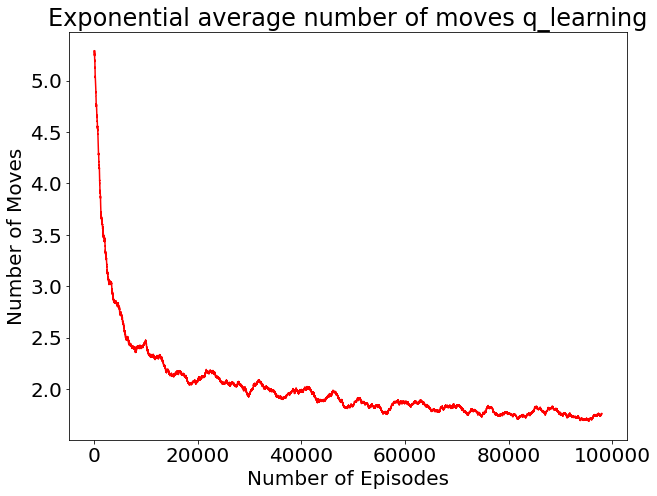

In [204]:
# Plot: number of moves
plt.rcParams.update({'font.size': 20})

plt.plot(figsize=(15,10))
plt.plot(np.arange(0,N_episodes-1999), moving_average(N_moves_save_q, n=2000), 'r')
plt.title("Exponential average number of moves q_learning")
plt.xlabel("Number of Episodes")
plt.ylabel("Number of Moves")
plt.show()

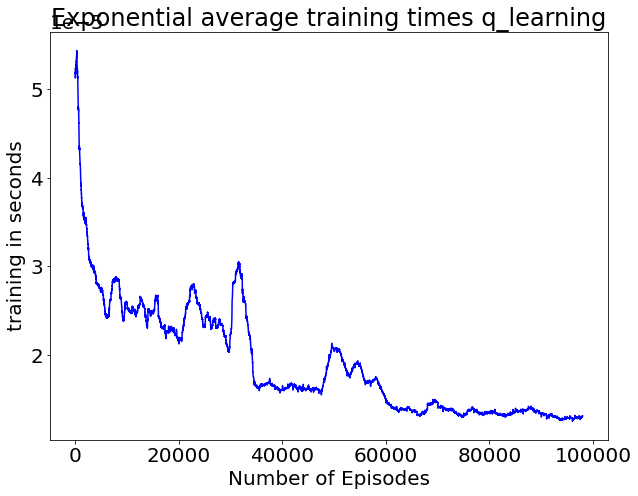

In [205]:
# Plot: training time
plt.rcParams.update({'font.size': 20})
plt.plot(figsize=(15,10))
plt.plot(np.arange(0,N_episodes-1999), moving_average(Training_time_per_episode_q, n=2000), 'b')
plt.title("Exponential average training times q_learning")
plt.xlabel("Number of Episodes")
plt.ylabel("training in seconds")
plt.show()



Q-Learning is an example of model-free learning algorithm. It does not assume that agent knows anything about the state-transition and reward models. However, the agent will discover what are the good and bad actions by trial and error.
The basic idea of Q-Learning is to approximate the state-action pairs Q-function from the samples of Q(s, a) that we observe during interaction with the enviornment. This approach is known as Time-Difference Learning.

# Deep SARSA Implementation

In [164]:
# HYPERPARAMETERS USED FOR SARSA (FOR A GRID SIZE OF 4)

epsilon_0 = 0.6    # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.01        # THE LEARNING RATE
N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 
memory_size = 2000 # THE SIZE OF THE MEMORY
reward_draw = 0  # THE REWARD FOR A DRAW, YOU CAN CHANGE THIS TO REPRODUCE OUR RESULTS TO -1
reward_check = 1 # THE REWARD FOR A CHECK

# SAVING VARIABLES
R_save_sarsa = np.zeros([N_episodes, 1])
N_moves_save_sarsa = np.zeros([N_episodes, 1])
Training_time_per_episode_sarsa = np.zeros([N_episodes, 1])

# PRINT AVERAGE REWARD EVERY NUMBER OF EPISODES
print_every = 500

In [165]:

agent = ChessAgent()

print(f"Average rewards for every {print_every} episodes:")
print('---------------------------------------')
for n in range(N_episodes):

    if n % print_every == 0 and n != 0:
      print('Average reward:',np.mean(R_save_sarsa[n-print_every:n]),'Number of steps: ',np.mean(N_moves_save_sarsa[n-print_every:n]), 'Training time: ',np.mean(Training_time_per_episode_sarsa[n-500:n]))

    start = time.time()
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game(reward_draw=reward_draw, reward_check=reward_check)      ## INITIALISE GAME

    action1 = agent.choose_action(X, allowed_a, epsilon_f)

    ep_reward = 0
    
    while Done==0:                           ## START THE EPISODE
        
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(action1)

        if agent.memory_counter >= memory_size:
              agent.train_sarsa()  

        if Done==1: 
          action2 = 0  # just to add something to the memory       
          agent.store_transition_sarsa(X, action1, action2, R, X_next, Done)
          R_save_sarsa[n]=np.copy(R)
          N_moves_save_sarsa[n]=np.copy(i)
          end = time.time()
          Training_time_per_episode_sarsa[n] = (abs(start-end)/1000)
          break
        
        action2 = agent.choose_action(X_next, allowed_a_next, epsilon_f)
        
        agent.store_transition_sarsa(X, action1, action2, R, X_next, Done)

       

        ## THE EPISODE HAS ENDED, UPDATE
        if Done==1:
          R_save_sarsa[n]=np.copy(R)
          N_moves_save_sarsa[n]=np.copy(i)
          end = time.time()
          Training_time_per_episode_sarsa[n] = (abs(start-end)/1000)
          break

        # IF THE EPISODE IS NOT OVER, ADD REWARD
        else:
          ep_reward += R
            
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        action1=np.copy(action2)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

Average rewards for every 500 episodes:
---------------------------------------
Average reward: 0.242 Number of steps:  7.64 Training time:  3.223934841156006e-05
Average reward: 0.352 Number of steps:  6.312 Training time:  4.215086936950683e-05
Average reward: 0.32 Number of steps:  5.208 Training time:  3.418144130706787e-05
Average reward: 0.4 Number of steps:  4.832 Training time:  3.2162192344665526e-05
Average reward: 0.382 Number of steps:  3.832 Training time:  2.6453997135162355e-05
Average reward: 0.432 Number of steps:  3.724 Training time:  2.607014322280884e-05
Average reward: 0.416 Number of steps:  3.298 Training time:  2.298554039001465e-05
Average reward: 0.48 Number of steps:  3.302 Training time:  2.2514482975006107e-05
Average reward: 0.434 Number of steps:  3.11 Training time:  2.1819334506988527e-05
Average reward: 0.466 Number of steps:  2.946 Training time:  2.0652868270874024e-05
Average reward: 0.49 Number of steps:  2.942 Training time:  2.0991457462310792e-

In [194]:
# Print average reward and average number of steps overall
print(f'Results over the whole sarsa training with {N_episodes} episodes:')
print('Trained_Agent, Average reward:',np.mean(R_save_sarsa),'Number of steps: ',np.mean(N_moves_save_sarsa), 'Average training time: ', np.mean(Training_time_per_episode_sarsa))

Results over the whole sarsa training with 100000 episodes:
Trained_Agent, Average reward: 0.71197 Number of steps:  2.20657 Average training time:  1.6422715866565705e-05


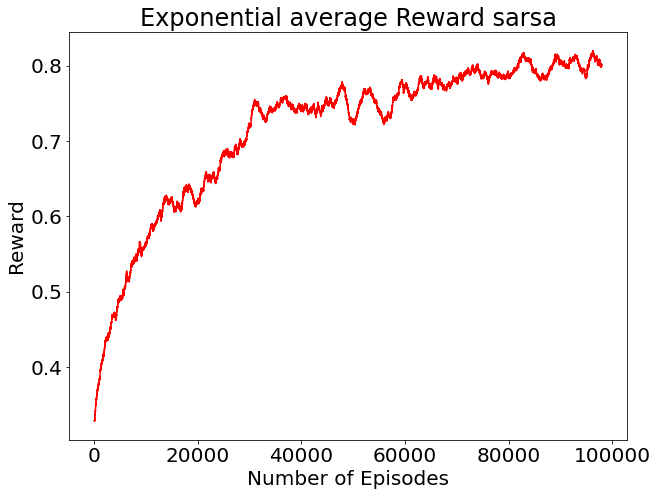

In [206]:
# Plot: Average reward exp
plt.rcParams.update({'font.size': 20})

plt.plot(figsize=(15,10))
plt.plot(np.arange(0,N_episodes-1999), moving_average(R_save_sarsa, n=2000), 'r')
plt.title("Exponential average Reward sarsa")
plt.xlabel("Number of Episodes")
plt.ylabel("Reward")
plt.show()

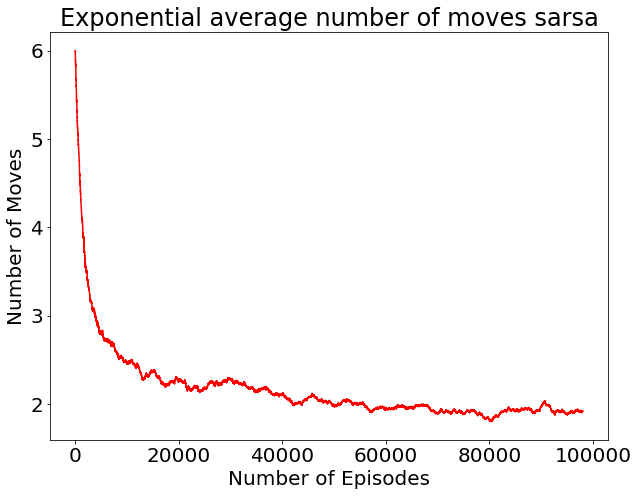

In [207]:
# Plot: number of moves
plt.rcParams.update({'font.size': 20})

plt.plot(figsize=(15,10))
plt.plot(np.arange(0,N_episodes-1999), moving_average(N_moves_save_sarsa, n=2000), 'r')
plt.title("Exponential average number of moves sarsa")
plt.xlabel("Number of Episodes")
plt.ylabel("Number of Moves")
plt.show()

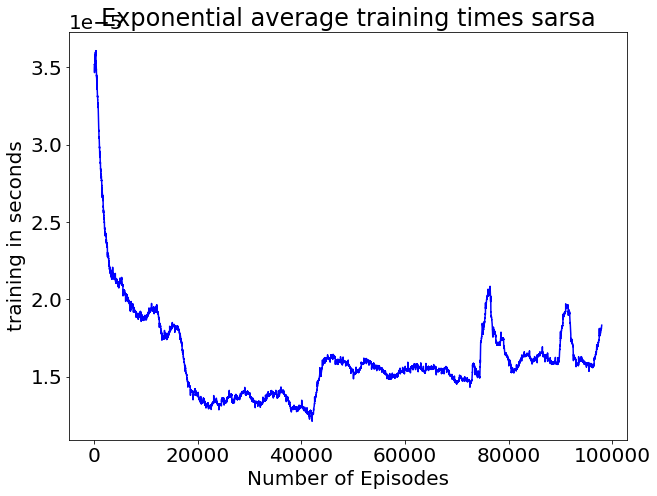

In [208]:
# Plot: training time
plt.rcParams.update({'font.size': 20})
plt.plot(figsize=(15,10))
plt.plot(np.arange(0,N_episodes-1999), moving_average(Training_time_per_episode_sarsa, n=2000), 'b')
plt.title("Exponential average training times sarsa")
plt.xlabel("Number of Episodes")
plt.ylabel("training in seconds")
plt.show()



# Deep Q_Learning vs SARS Comparision

In [198]:
# Print average reward and average number of steps overall
print(f'Results over the whole Q_learning training with {N_episodes} episodes:')
print('Trained_Agent, Average reward:',np.mean(R_save_q),'Number of steps: ',np.mean(N_moves_save_q))

# Print average reward and average number of steps overall
print(f'Results over the whole SARSA training with {N_episodes} episodes:')
print('Trained_Agent, Average reward:',np.mean(R_save_sarsa),'Number of steps: ',np.mean(N_moves_save_sarsa))



Results over the whole Q_learning training with 100000 episodes:
Trained_Agent, Average reward: 0.65191 Number of steps:  2.05328
Results over the whole SARSA training with 100000 episodes:
Trained_Agent, Average reward: 0.71197 Number of steps:  2.20657


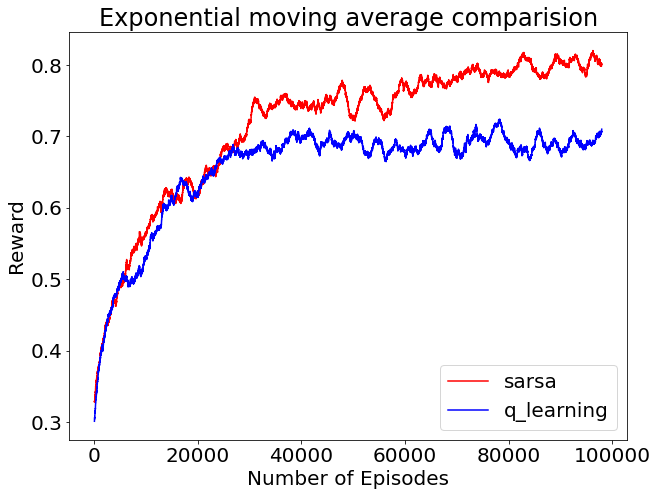

In [209]:
# Plot: Reward per game exponential
plt.rcParams.update({'font.size': 20})
plt.plot(figsize=(15,10))
plt.plot(np.arange(0,N_episodes-1999), moving_average(R_save_sarsa, n=2000), 'r', label='sarsa')
plt.plot(np.arange(0,N_episodes-1999), moving_average(R_save_q, n=2000), 'b', label='q_learning')
plt.xlabel("Number of Episodes")
plt.ylabel("Reward")
plt.title("Exponential moving average comparision")
plt.legend()
plt.show()

